<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Line-intersection" data-toc-modified-id="Line-intersection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Line intersection</a></span></li><li><span><a href="#Benchmark---putting-stuff-on-the-GPU" data-toc-modified-id="Benchmark---putting-stuff-on-the-GPU-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Benchmark - putting stuff on the GPU</a></span></li><li><span><a href="#Raycaster---Parallelizing-segments-and-poses" data-toc-modified-id="Raycaster---Parallelizing-segments-and-poses-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Raycaster - Parallelizing segments and poses</a></span><ul class="toc-item"><li><span><a href="#CPU-version" data-toc-modified-id="CPU-version-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CPU version</a></span></li><li><span><a href="#CUDA-version" data-toc-modified-id="CUDA-version-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CUDA version</a></span></li><li><span><a href="#Combined-version" data-toc-modified-id="Combined-version-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Combined version</a></span></li><li><span><a href="#Examples" data-toc-modified-id="Examples-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Examples</a></span></li></ul></li></ul></div>

# CUDA 2D Raycaster for Line Maps with Segment IDs

In [2]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [1]:
#nbx --fname="src/cuda_raycaster_line_map_c.jl"
push!(LOAD_PATH, "src");
using MyUtils
using CUDA
using MyCudaUtils
using BenchmarkTools
using Colors, Plots
col = palette(:default);
import Base: @doc

In [2]:
include("./src/pose.jl");
using Geometry: Segment

## Line intersection

To do raycsting we need to compute the intersection of two lines by solving: $x + s \cdot dx = y + t \cdot dy$.

Implementation from my `Geometry.jl` package:

```julia
function line_intersect(x, x′, y, y′)
    dx = x′ - x
    dy = y′ - y
    v  = x - y
    if det([-dx dy]) == 0
        return [Inf;Inf]
    end
    s, t = inv([-dx dy])*v
    return s,t
end;
```

And here's a version without arrays that we can use within a cuda kernel later.

In [3]:
function intersections(x, x′, y, y′)
    n = ndims(x)
    dx = x′ .- x
    dy = y′ .- y
    v  = x .- y

    dx1 = selectdim(dx, n, 1)
    dx2 = selectdim(dx, n, 2)
    dy1 = selectdim(dy, n, 1)
    dy2 = selectdim(dy, n, 2)
    v1 = selectdim(v, n, 1)
    v2 = selectdim(v, n, 2)

    a, b = -dx1, dy1
    c, d = -dx2, dy2

    det = a.*d .- b.*c
    
    s = 1 ./det .*(  d.*v1 .- b.*v2)
    t = 1 ./det .*(- c.*v1 .+ a.*v2)
    return s,t, x .+ s.*dx, y .+ t.*dy
end

intersections (generic function with 1 method)

In [209]:
# function intersections(x, x′, y, y′)

#     dx = x′ .- x
#     dy = y′ .- y
#     v  = x .- y

#     a, b = -dx[:,:,1], dy[:,:,1]
#     c, d = -dx[:,:,2], dy[:,:,2]

#     det = a.*d .- b.*c
    
#     s = 1 ./det .*(  d.*v[:,:,1] .- b.*v[:,:,2])
#     t = 1 ./det .*(- c.*v[:,:,1] .+ a.*v[:,:,2])
#     return s,t, x .+ s.*dx, y .+ t.*dy
# end

intersections (generic function with 1 method)

In [4]:
create_angles(fov, num_a) = [range(-fov/2, fov/2, num_a)...];

In [49]:
function cast(v0::AbstractVector, as_::CuArray, segs_::CuArray; zmax=Inf)
    x  = view(v0, 1:2)
    hd = view(v0, 3)
    as_ = as_ .+ hd
    x_  = CuArray(x)
    x′_ = reshape(x_,1,2) .+ cat(cos.(as_), sin.(as_), dims=2)
    y_  = view(segs_,:,1:2)
    y′_ = view(segs_,:,3:4)

    x_  = reshape(x_ , :, 1, 2)
    x′_ = reshape(x′_, :, 1, 2)
    y_  = reshape(y_ , 1, :, 2)
    y′_ = reshape(y′_, 1, :, 2)

    s_, t_, _, _ = intersections(x_, x′_, y_, y′_)

    # Hit map
    h_ = (0 .< s_) .* (0 .<= t_ .<= 1)
    s_[.!h_] .= zmax

    # Segment-ID
    i_  = argmin(s_, dims=2)[:,1]
    i2_ = map(i->i[2],i_);
    
    # Todo: There was an issue when I computed `z_ = s_[i_]`
    #       Not sure why... but using minimum() works
    z_ = minimum(s_, dims=2)[:,1]
    i2_[z_.==zmax] .= 0

    # Depth and Segment-ID
    return z_, i2_
end;

In [53]:
function cast(vs::Array, as::Vector, segs::Array; zmax=Inf)
    vs_   = CuArray(vs)
    as_   = CuArray(as)
    segs_ = CuArray(segs)
    map(v_->cast(v_, as_, segs_, zmax=zmax), eachslice(vs_, dims=1))
end;

In [56]:
_fov   = π
_num_a = 100

vs   = rand(500,3)
segs = 5*(rand(1_000,4))
as   = create_angles(_fov, _num_a)

@btime cast($vs, $as, $segs) samples=1 evals=5;


  795.694 ms (804302 allocations: 663.31 MiB)


In [5]:
# Todo: Turn in to cast_cpu and cast_gpu and cast
"""
    zs, is = cast(v0, as::Vector, segs::Array; zmax=Inf)

Returns depth measurements and segment-IDs for a given 
pose vector `v0` and a set of segments `segs` and angles `as`.
"""
function cast(v0::Vector, as::Vector, segs::Array; zmax=Inf)
    as_   = CuArray(as .+ v0[3])
    segs_ = CuArray(segs)

    x_  = CuArray(v0[1:2])
    x′_ = cat(v0[1] .+ cos.(as_), v0[2] .+ sin.(as_), dims=2)
    y_  = view(segs_,:,1:2)
    y′_ = view(segs_,:,3:4)

    x_  = reshape(x_ , :, 1, 2)
    x′_ = reshape(x′_, :, 1, 2)
    y_  = reshape(y_ , 1, :, 2)
    y′_ = reshape(y′_, 1, :, 2)

    s_, t_, _, _ = intersections(x_, x′_, y_, y′_)

    # Hit map
    h_ = (0 .< s_) .* (0 .<= t_ .<= 1)
    s_[.!h_] .= zmax

    # Segment-ID
    i_  = argmin(s_, dims=2)[:,1]
    i2_ = map(i->i[2],i_);
    
    # Todo: There was an issue when I computed `z_ = s_[i_]`
    #       Not sure why... but using minimum() works
    z_ = minimum(s_, dims=2)[:,1]
    i2_[z_.==zmax] .= 0

    # Depth and Segment-ID
    return Array(z_), Array(i2_)
end;

cast(p::Pose, as::Vector, segs::Array; zmax=Inf) = cast(Vector(p), as, segs; zmax=zmax);

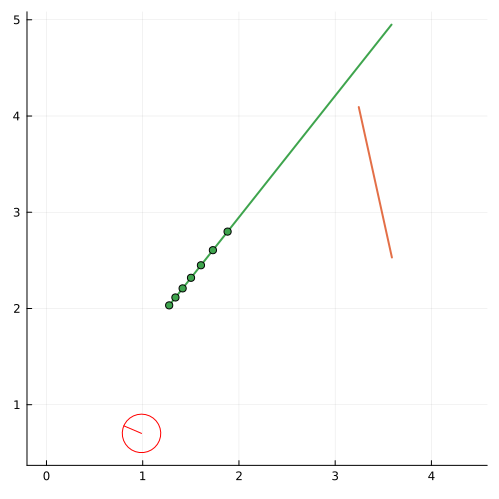

In [10]:
_fov = π
_num_a = 100

p    = Pose(rand(2), rand()*2π)
segs = 5*(rand(2,4))

as   = create_angles(_fov, _num_a)
ws   = 1:size(segs,1)+1
col = palette(:default);

zs, is = cast(p, as, segs)
ys = polar_inv(zs, as);

# --------------
mypl = plot(size=(500,500), aspect_ratio=:equal, legend=nothing, 
    # xlim=(-5,5), ylim=(-5,5)
)
plot!(p,c=:red, r=:0.2)
plot!(segs[:,[1,3]]', segs[:,[2,4]]', color = col[ws.+1]', linewidth=2)
for (i,y) in zip(is,ys)
    scatter!([y*p], c=col[i+1], alpha=1.)
end
mypl

### Combined version

2D raycaster for *line maps* in Julia, which automatically switches between CPU and CUDA acceleration.



In [19]:
#nbx
create_angles(fov, num_a) = [range(-fov/2, fov/2, num_a)...];
export create_angles

In [ ]:
#nbx
"""
```julia
    zs = cast(ps, segs; fov=2π, num_a::Int=361, zmax::Float64=Inf)
```
Computes depth measurements `zs` with respect to a family of stacked poses `ps`
and family of stacked line segments `segs` along a fixed number `num_a` of
equidistantly spaced angles in the field of view `fov`.

If a CUDA supported GPU is available we run a GPU accelerated version.

Arguments:
 - `ps`: Stacked poses `(k, 3)`
 - `segs`: Stacked line segments `(n, 4)`
 - ...

Returns:
 - `zs`: Depth measurements in the field of view `(k, num_a)`
"""
function cast(ps::Array, segs::Array; fov=2π, num_a::Int=361, zmax::Float64=Inf)
    if _cuda[]
        ps_   = CuArray(ps)
        segs_ = CuArray(segs)
        zs_   = cast_cu(ps_, segs_; fov=fov, num_a=num_a, zmax=zmax)
        return Array(zs_)
    else
        return cast_cpu(ps, segs; fov=fov, num_a=num_a, zmax=zmax)
    end
end;

function cast(ps_::CuArray, segs_::CuArray; fov=2π, num_a::Int=361, zmax::Float64=Inf)
    return cast_cu(ps_, segs_; fov=fov, num_a=num_a, zmax=zmax)
end

export cast

In [ ]:
n = 500 # num segments
m = 500 # num poses
x = 5*(2*rand(n,4).-1.0)
p = zeros(m, 3)

# -------------------------------
println("CUDA available: $(_cuda[])")
println("x: $(size(x)), p: $(size(p))")
println("`cast`")
@btime cast($p,$x) samples=3 evals=3;

### Examples

In [33]:
include("./src/pose.jl");
using Geometry: Segment

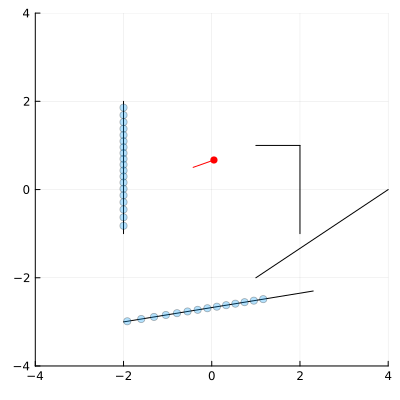

In [34]:
segs = [
    Segment([1.,1.,2.,1.]),
    Segment([2.,1.,2.,-1.]),
    Segment([1.,-2.,4.,0.]),
    Segment([-2.,2.,-2.,-1.]),
    Segment([-2.,-3.,2.3,-2.3]),
]

m     = 10
fov   = π
num_a = 50

ps = [Pose(rand(2), rand()*2π) for i=1:m]

zs = cast(stack(Vector.(ps)), stack(Vector.(segs)); fov=fov, num_a=num_a, zmax=Inf)
as = create_angles(fov, num_a)
zs = unstack(zs)
ys = polar_inv.(zs,[as])

# ----------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing, 
    xlim=(-4,4),
    ylim=(-4,4)
)
plot!(segs, c=:black)
scatter!(ys[1].*ps[1], c=col[1], alpha=0.3)
scatter!(ps[1], r=0.5, c=:red, alpha=1.)

    